osmid  oneway lanes  ref  \
u          v          key                                
382382752  477218398  0    33524863   False   NaN  NaN   
477218398  1714744102 0    33524863   False   NaN  NaN   
           382382752  0    33524863   False   NaN  NaN   
1714744102 477218398  0    33524863   False   NaN  NaN   

                                                 name   highway reversed  \
u          v          key                                                  
382382752  477218398  0    Boulevard de la République  tertiary    False   
477218398  1714744102 0    Boulevard de la République  tertiary    False   
           382382752  0    Boulevard de la République  tertiary     True   
1714744102 477218398  0    Boulevard de la République  tertiary     True   

                            length  \
u          v          key            
382382752  477218398  0    158.697   
477218398  1714744102 0     40.408   
           382382752  0    158.697   
1714744102 477218398  0     40.408   

                                                                    geometry  \
u          v          key                                                      
382382752  477218398  0    LINESTRING (6.36063 43.49310, 6.36015 43.49311...   
477218398  1714744102 0    LINESTRING (6.35867 43.49317, 6.35837 43.49318...   
           382382752  0    LINESTRING (6.35867 43.49317, 6.35884 43.49316...   
1714744102 477218398  0    LINESTRING (6.35817 43.49319, 6.35837 43.49318...   

                          maxspeed junction width bridge access  
u          v          key                                        
382382752  477218398  0        NaN      NaN   NaN    NaN    NaN  
477218398  1714744102 0        NaN      NaN   NaN    NaN    NaN  
           382382752  0        NaN      NaN   NaN    NaN    NaN  
1714744102 477218398  0        NaN      NaN   NaN    NaN    NaN

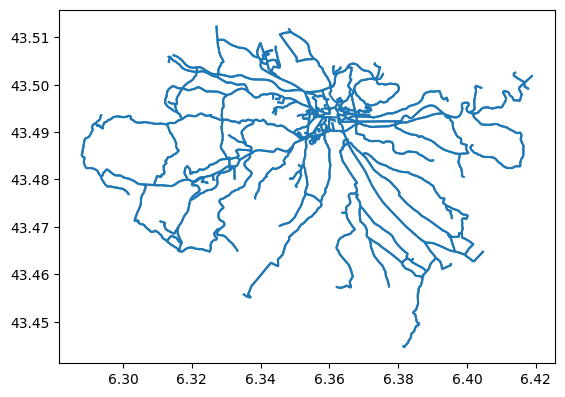

In [4]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
ox.settings.log_console = True
ox.settings.max_query_area_size = 25e12

Commune = "Lorgues" #on choisit comme exmple la Commune de Lorgues

graph = ox.graph_from_place(Commune, network_type='drive')
gdf_nodes, gdf_edges = ox.graph_to_gdfs(
        graph,
        nodes=True, edges=True,
        node_geometry=True,
        fill_edge_geometry=True)

routes_gdf = gdf_edges
routes_gdf.plot() #Les routes situant dans la Commune de Lorgues

routes_piettonisation = 'Boulevard de la République' #on choisit comme exmple le Boulevard de la République

gdf_republique = routes_gdf.loc[routes_gdf['name'] == routes_piettonisation] #le geodataframe du Boulevard de la République
len(gdf_republique)
gdf_republique

In [5]:
def buffer_route(routes_gdf,d): #Création d'une zone tampon de la route   
        
    routes_gdf = routes_gdf.to_crs(epsg=2154) #pour prendre en concidération la distance en mètres avant la réalisation du buffer
    
    routes_buffered = routes_gdf.buffer(d,resolution=20)
    
    routes_buffered = routes_buffered.to_crs(epsg=4326)
 
    routes_buffered_union = routes_buffered.unary_union
    
    gdf_routes_buffered_union = gpd.GeoDataFrame(geometry=[routes_buffered_union])

    return(gdf_routes_buffered_union)

a = buffer_route(gdf_republique,15)

In [6]:
type(a)

geopandas.geodataframe.GeoDataFrame

<Axes: >

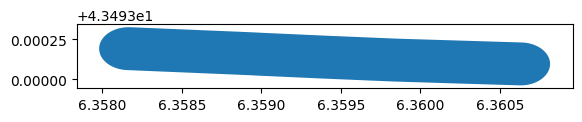

In [7]:
a.plot()

In [8]:
len(a)

1

In [9]:
import mercantile
import requests
from vt2geojson.tools import vt_bytes_to_geojson
from concurrent.futures import ThreadPoolExecutor
from shapely.geometry import box, shape
import geopandas as gpd
import os, json
import functools

# Choix de type de tuiles vectorielles
def choose_data_type(data_type):
    if (data_type == "tile_points"):
        return("mly_map_feature_point")
    elif (data_type == "tile_traffic_signs"):
        return("mly_map_feature_traffic_sign")

# Charger le fichier tabulaire contenant la clé Token d'accès Mapillary
with open("../notebooks/mapillary_token.txt", encoding="utf-8") as f:
    access_token = f.read()

# Fonction pour créer la zone tampon
def buffer_route(routes_gdf,d): #Création d'une zone tampon de la route   
        
    routes_gdf = routes_gdf.to_crs(epsg=2154) #pour prendre en concidération la distance en mètres avant la réalisation du buffer
    
    routes_buffered = routes_gdf.buffer(d,resolution=20)
    
    routes_buffered = routes_buffered.to_crs(epsg=4326)
 
    routes_buffered_union = routes_buffered.unary_union
    
    gdf_routes_buffered_union = gpd.GeoDataFrame(geometry=[routes_buffered_union])

    return(gdf_routes_buffered_union)

# Fonction pour filtrer les entités qui intersectent la zone tampon
def filter_features(features, polygon):
    filtered_features = []
    for feature in features:
        geom = shape(feature['geometry'])
        if geom.intersects(polygon):
            filtered_features.append(feature)
    return filtered_features

# Fonction pour récupérer les données d'une tuile vectorielle
def fetch_tile(tile, data_type):
    tile_url = f'https://tiles.mapillary.com/maps/vtp/{choose_data_type(data_type)}/2/{tile.z}/{tile.x}/{tile.y}?access_token={access_token}'
    response = requests.get(tile_url)
    data = vt_bytes_to_geojson(response.content, tile.x, tile.y, tile.z)

    #choisir les type selon les valeurs des entités
    filtered_data = [feature for feature in data['features'] if feature['properties']['value'] in filter_values]
    return (filtered_data)

#def fetch_tile_traffic_sign(tile):
    #return fetch_tile(tile, 'tile_traffic_signs')

#def fetch_tile_points(tile):
    #return fetch_tile(tile, 'tile_points')

# Récupérer les données (selon choix : points ou panneaux de signalisation) depuis l'API de Mapillary
def get_mapillary_data(data_type, access_token, highways, output_folder):
    # créer la zone tampon de la route choisie
    buffered = buffer_route(highways,20)
    
    # Les coordonnées du Bounding box de la zone tampon de la route choisie
    minx, miny, maxx, maxy = buffered.bounds['minx'].values[0],buffered.bounds['miny'].values[0],buffered.bounds['maxx'].values[0],buffered.bounds['maxy'].values[0]
    (W, S, E, N) = (minx, miny, maxx, maxy)
    
    # Définir un GeoJSON vide en tant que sortie
    output = {"type": "FeatureCollection", "features": []}

    # Récupérer la liste des tuiles intersectant notre bounding box
    tiles = list(mercantile.tiles(W, S, E, N, zooms=[14]))
    
    # Créer un polygone à partir de la bounding box
    bbox_polygon = box(W, S, E, N)
    gdf_bbox = gpd.GeoDataFrame({'geometry': [bbox_polygon]}, crs='EPSG:4326')

    # Utilisation de functools.partial pour fixer la valeur de l'argument 'data_type' dans la fonction fetch_tile
    partial_fetch_tile = functools.partial(fetch_tile, data_type=data_type)

    # Exécuter les requêtes en parallèle vu le nombre important des tuiles
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(partial_fetch_tile, tiles))

    # Filtrer les resultats des entités contenues dans la zone tampon
    for features in results:
        filtered_features = filter_features(features, buffered)
        output['features'].extend(filtered_features)

    # Export du fichier résultat sous fromat geojson
    with open(output_folder, "w") as fx:
        json.dump(output, fx)
        gdf_mapillary = gpd.GeoDataFrame.from_features(output)
    return(gdf_mapillary,buffered)

# Visualisation :
from ipyleaflet import Map, GeoJSON, GeoData, ZoomControl

import geopandas, pandas as pd, numpy as np

highways = gdf_republique

data_type = "tile_points"
filter_values = ["object--street-light"]
Name = "Eclairage_highways_Mly"
output_folder = "../data/processed/"+Name+".geojson"
Eclairage_mapillary,highways_buffered = get_mapillary_data(data_type, access_token, highways, output_folder)
print("end")

C:\Users\alaeddine.jerad\AppData\Local\Programs\Python\Python312\Lib\site-packages\mapbox_vector_tile\__init__.py:36: DeprecationWarning: `decode` signature has changed, use `default_options` instead
  warnings.warn("`decode` signature has changed, use `default_options` instead", DeprecationWarning)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
def render_map(data, pol):
    
    m = Map(center=(pol.bounds['miny'].values[0],pol.bounds['minx'].values[0]))

    # Visualisation des données extraites
    geo_data1 = GeoData(geo_dataframe = data,
        style={'color': 'black', 'radius':3, 'fillColor': '#cc3333', 'opacity':1, 'weight':1, 'dashArray':'2', 'fillOpacity':1},
        hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
        point_style={'radius': 5, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
        name = 'Release')

    # Visualisation du polygone d'extraction
    geo_data2 = GeoData(geo_dataframe = pol,
        style={'color': 'blue', 'radius':2, 'fillColor': '#004dff', 'opacity':1, 'weight':2, 'dashArray':'1', 'fillOpacity':0})
    
    m.add(geo_data2)
    m.add(geo_data1)

    m.fit_bounds([[pol.bounds['miny'].values[0], pol.bounds['minx'].values[0]], # Ajuster le zoom et centrer la carte pour afficher les limites du polygone
              [pol.bounds['maxy'].values[0], pol.bounds['maxx'].values[0]]])
    
    display(m)

render_map(Eclairage_mapillary, highways_buffered)